In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Start from here 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets, models, transforms
from PIL import Image, ImageOps
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2


In [ ]:
# Define the padding and resize function with gray padding
def padding_and_resize(img, target_size=224, fill=(128, 128, 128)):
    w, h = img.size
    if w != h:
        if w > h:
            delta = w - h
            padding = (0, delta // 2, 0, delta - delta // 2)
        else:
            delta = h - w
            padding = (delta // 2, 0, delta - delta // 2, 0)
        img = ImageOps.expand(img, padding, fill=fill)
    img = img.resize((target_size, target_size), Image.Resampling.BILINEAR)
    return img

# Apply CLAHE to enhance contrast
def apply_clahe(img):
    img_np = np.array(img.convert('L'))  # Convert to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_np)
    img = Image.fromarray(cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB))
    return img


In [ ]:
# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001, path='/kaggle/working/stage1_best.pth'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_loss = float('inf')
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            print(f"Model saved with val_loss: {val_loss:.4f}")
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Define transforms
base_transform = transforms.Compose([
    transforms.Lambda(lambda img: apply_clahe(img)),
    transforms.Lambda(lambda img: padding_and_resize(img, 224, fill=(128, 128, 128))),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

general_augment_transform = transforms.Compose([
    transforms.Lambda(lambda img: apply_clahe(img)),
    transforms.Lambda(lambda img: padding_and_resize(img, 224, fill=(128, 128, 128))),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dr_augment_transform = transforms.Compose([
    transforms.Lambda(lambda img: apply_clahe(img)),
    transforms.Lambda(lambda img: padding_and_resize(img, 224, fill=(128, 128, 128))),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Define BinaryDataset
class BinaryDataset(Dataset):
    def __init__(self, dataset, base_transform=None, general_augment_transform=None, dr_augment_transform=None, is_train=False):
        self.dataset = dataset
        self.base_transform = base_transform
        self.general_augment_transform = general_augment_transform
        self.dr_augment_transform = dr_augment_transform
        self.is_train = is_train

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.is_train:
            if label != 0:
                img = self.dr_augment_transform(img)
            else:
                img = self.general_augment_transform(img)
        else:
            img = self.base_transform(img)
        binary_label = 0 if label == 0 else 1
        return img, binary_label

In [ ]:

# Load datasets
data_dir = "/kaggle/input/dr-dataset/BPEF_WORKSHOPS/EyePACS"
full_train_dataset_raw = datasets.ImageFolder(root=f"{data_dir}/train", transform=None)
val_dataset_raw = datasets.ImageFolder(root=f"{data_dir}/test", transform=None)

# Create datasets with is_train flag
train_dataset = BinaryDataset(full_train_dataset_raw, base_transform=base_transform, general_augment_transform=general_augment_transform, dr_augment_transform=dr_augment_transform, is_train=True)
val_dataset = BinaryDataset(val_dataset_raw, base_transform=base_transform, general_augment_transform=general_augment_transform, dr_augment_transform=dr_augment_transform, is_train=False)


In [ ]:

# Compute class weights for sampler and loss
train_labels = [0 if l == 0 else 1 for l in full_train_dataset_raw.targets]
class_counts = Counter(train_labels)
class_weights = [1.0 / class_counts[i] for i in range(2)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights = class_weights / class_weights.sum() * 2  # Normalize
sample_weights = [class_weights[label].item() for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))


In [ ]:
# Data loaders
train_loader_stage1 = DataLoader(train_dataset, batch_size=64, sampler=sampler, pin_memory=True)
val_loader_stage1 = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)


In [ ]:
# Model
model_stage1 = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
# Unfreeze last block of features
for param in model_stage1.features[-3:].parameters():
    param.requires_grad = True
num_ftrs = model_stage1.classifier[3].in_features
model_stage1.classifier[3] = nn.Linear(num_ftrs, 2)
model_stage1 = model_stage1.to(device)


In [ ]:
# Loss and optimizer
criterion_stage1 = nn.CrossEntropyLoss(weight=class_weights)
optimizer_stage1 = optim.Adam(model_stage1.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_stage1, mode='min', factor=0.1, patience=3)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 159MB/s]


Starting training...


Stage1 Epoch 1/20: 100%|██████████| 17/17 [04:45<00:00, 16.81s/it]


Stage1 Epoch 1: Train Loss 0.4879, Train Acc 0.5607, Val Loss 0.7999, Val Acc 0.3776, Macro F1 0.3754
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.21      0.34       398
           1       0.27      0.89      0.41       129

    accuracy                           0.38       527
   macro avg       0.56      0.55      0.38       527
weighted avg       0.71      0.38      0.36       527



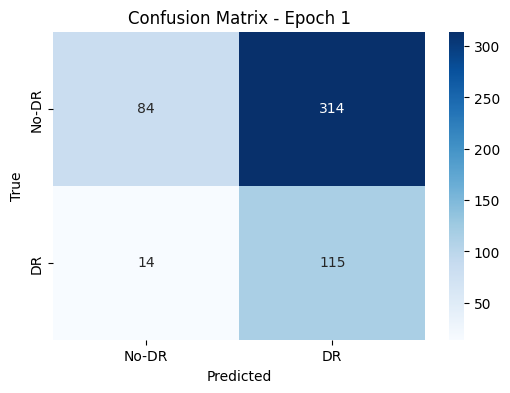

Model saved with val_loss: 0.7999


Stage1 Epoch 2/20: 100%|██████████| 17/17 [04:38<00:00, 16.40s/it]


In [ ]:

# Early stopping
early_stopping = EarlyStopping(patience=5, delta=0.001)

# Training loop
train_losses, train_accs = [], []
val_losses, val_accs, val_macro_f1s = [], [], []

print("Starting training...")

for epoch in range(20):  # Increased epochs due to lower learning rate
    # Training Phase
    model_stage1.train()
    running_loss, correct, total = 0, 0, 0
    
    for inputs, labels in tqdm(train_loader_stage1, desc=f"Stage1 Epoch {epoch+1}/20"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_stage1.zero_grad()
        outputs = model_stage1(inputs)
        loss = criterion_stage1(outputs, labels)
        loss.backward()
        optimizer_stage1.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader_stage1.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Validation Phase
    model_stage1.eval()
    val_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in val_loader_stage1:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_stage1(inputs)
            loss = criterion_stage1(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_loss /= len(val_loader_stage1.dataset)
    val_acc = correct / total
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_macro_f1s.append(macro_f1)
    
    print(f"Stage1 Epoch {epoch+1}: Train Loss {epoch_loss:.4f}, Train Acc {epoch_acc:.4f}, Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}, Macro F1 {macro_f1:.4f}")
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No-DR', 'DR'], yticklabels=['No-DR', 'DR'])
    plt.title(f'Confusion Matrix - Epoch {epoch+1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Early stopping and scheduler
    early_stopping(val_loss, model_stage1)
    scheduler.step(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

print("Training complete.")

# Load best model
model_stage1.load_state_dict(torch.load("/kaggle/working/stage1_best.pth"))
print("Stage 1 model loaded!")

In [ ]:
import torch
from torchvision import transforms, models
from PIL import Image, ImageOps
import cv2
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Padding & resize function with gray padding
def padding_and_resize(img, target_size=224, fill=(128, 128, 128)):
    w, h = img.size
    if w != h:
        if w > h:
            delta = w - h
            padding = (0, delta // 2, 0, delta - delta // 2)
        else:
            delta = h - w
            padding = (delta // 2, 0, delta - delta // 2, 0)
        img = ImageOps.expand(img, padding, fill=fill)
    img = img.resize((target_size, target_size), Image.Resampling.BILINEAR)
    return img

# Apply CLAHE for contrast enhancement
def apply_clahe(img):
    img_np = np.array(img.convert('L'))  # Convert to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_np)
    img = Image.fromarray(cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB))
    return img

# Transform for inference (matches training/validation base_transform)
stage1_transform = transforms.Compose([
    transforms.Lambda(lambda img: apply_clahe(img)),
    transforms.Lambda(lambda img: padding_and_resize(img, 224, fill=(128, 128, 128))),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Stage 1 model
model_stage1 = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
num_ftrs = model_stage1.classifier[3].in_features
model_stage1.classifier[3] = torch.nn.Linear(num_ftrs, 2)
model_stage1.load_state_dict(torch.load("/kaggle/working/stage1_best.pth"))
model_stage1 = model_stage1.to(device)
model_stage1.eval()

# Inference function
def predict_stage1(img_paths):
    results = []
    for img_path in img_paths:
        try:
            img = Image.open(img_path).convert("RGB")
            input_tensor = stage1_transform(img).unsqueeze(0).to(device)
            
            with torch.no_grad():
                output = model_stage1(input_tensor)
                probs = torch.softmax(output, dim=1)
                pred_class = torch.argmax(probs, dim=1).item()
                confidence = probs[0, pred_class].item()
            
            results.append((img_path, pred_class, confidence))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            results.append((img_path, None, None))
    return results

# Example usage
image_paths = [
    "/kaggle/input/dr-dataset/BPEF_WORKSHOPS/EyePACS/train/3/23787_left.jpeg",
    "/kaggle/input/dr-dataset/BPEF_WORKSHOPS/EyePACS/test/0/10050_left.jpeg",
    "/kaggle/input/dr-dataset/BPEF_WORKSHOPS/EyePACS/test/0/10451_left.jpeg"
    # Add more image paths here for batch inference,
]
results = predict_stage1(image_paths)
for img_path, pred_class, conf in results:
    if pred_class is not None:
        print(f"Image: {img_path}, Predicted Class: {pred_class} (0: No-DR, 1: DR), Confidence: {conf:.4f}")
    else:
        print(f"Image: {img_path}, Failed to process")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import os

# Create output dir
out_dir = "/kaggle/working/metrics_stage11"
os.makedirs(out_dir, exist_ok=True)

# -------------------------------
# 1. Plot Loss & Accuracy curves
# -------------------------------
plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.savefig(f"{out_dir}/loss_acc_curves.png")
plt.show()

# -------------------------------
# 2. Macro F1 curve
# -------------------------------
plt.figure(figsize=(7,5))
plt.plot(val_macro_f1s, marker='o', label='Val Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.title('Validation Macro F1 Curve')
plt.legend()
plt.savefig(f"{out_dir}/macro_f1_curve.png")
plt.show()

# -------------------------------
# 3. Per-class metrics
# -------------------------------
# Run final evaluation on validation set
model_stage1.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in val_loader_stage1:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_stage1(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report (text)
report = classification_report(all_labels, all_preds, digits=4)
print("\nClassification Report:\n")
print(report)

with open(f"{out_dir}/classification_report.txt", "w") as f:
    f.write(report)

# Arrays of precision, recall, f1 per class
prec, rec, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None)
np.savez(f"{out_dir}/per_class_metrics.npz",
         precision=prec, recall=rec, f1=f1, support=support)

# -------------------------------
# 4. Confusion Matrix
# -------------------------------
cm = confusion_matrix(all_labels, all_preds)
class_names = [str(i) for i in range(len(cm))]  # adjust if you have custom labels

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(f"{out_dir}/confusion_matrix.png")
plt.show()


# 2nd Step

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms, models
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, confusion_matrix, classification_report
import copy

In [ ]:
# Custom dataset wrapper to filter classes and remap labels
class FilteredImageFolder(Dataset):
    def __init__(self, root, transform=None, exclude_classes=[0], label_map=None):
        self.dataset = datasets.ImageFolder(root, transform=transform)
        self.indices = [idx for idx, (_, label) in enumerate(self.dataset) if label not in exclude_classes]
        if label_map is None:
            # Automatically remap labels to 0-(num_classes-1)
            unique_labels = sorted(set(self.dataset.targets[idx] for idx in self.indices))
            self.label_map = {old: new for new, old in enumerate(unique_labels)}
        else:
            self.label_map = label_map
        self.num_classes = len(self.label_map)

    def __getitem__(self, index):
        img, label = self.dataset[self.indices[index]]
        new_label = self.label_map.get(label, -1)
        if new_label == -1:
            raise ValueError(f"Unexpected label {label}")
        return img, new_label

    def __len__(self):
        return len(self.indices)

In [ ]:
# Function to compute class weights for imbalanced dataset
def compute_class_weights(dataset):
    labels = [label for _, label in dataset]
    class_counts = np.bincount(labels)
    weights = 1. / class_counts
    weights = weights / weights.sum() * len(class_counts)  # Normalize
    return torch.tensor(weights, dtype=torch.float32)


In [ ]:
# Custom transform function
def padding_and_resize(img, target_size=224, fill=(128,128,128)):
    w, h = img.size
    if w != h:
        if w > h:
            delta = w - h
            padding = (0, delta // 2, 0, delta - delta // 2)
        else:
            delta = h - w
            padding = (delta // 2, 0, delta - delta // 2, 0)
        img = ImageOps.expand(img, padding, fill=fill)
    img = img.resize((target_size, target_size), Image.Resampling.BILINEAR)
    return img

In [ ]:
# Data loading
def load_data(train_dir, val_dir, batch_size=32):
    transform_train = transforms.Compose([
        transforms.Lambda(lambda img: padding_and_resize(img)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    transform_val = transforms.Compose([
        transforms.Lambda(lambda img: padding_and_resize(img)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Assuming classes are folders '0', '1', '2', '3', '4' and we exclude '0'
    # Labels 1->0, 2->1, 3->2, 4->3
    label_map = {1: 0, 2: 1, 3: 2, 4: 3}

    train_dataset = FilteredImageFolder(train_dir, transform=transform_train, exclude_classes=[0], label_map=label_map)
    val_dataset = FilteredImageFolder(val_dir, transform=transform_val, exclude_classes=[0], label_map=label_map)

    class_weights = compute_class_weights(train_dataset)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, class_weights, train_dataset.num_classes


In [ ]:
# Model setup
def get_model(num_classes):
    model = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
    # Modify the classifier for 4 classes
    model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    return model

In [ ]:
# Training function with early stopping
def train_model(model, train_loader, val_loader, class_weights, num_epochs=50, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        scheduler.step()

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs


In [ ]:
# Plot curves
def plot_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training acc')
    plt.plot(epochs, val_accs, 'ro-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()


In [ ]:
# Evaluation
def evaluate_model(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=['Class 1 (0)', 'Class 2 (1)', 'Class 3 (2)', 'Class 4 (3)']))
    print('F1 Score:', f1_score(all_labels, all_preds, average='weighted'))
    print('Recall:', recall_score(all_labels, all_preds, average='weighted'))
    cm = confusion_matrix(all_labels, all_preds)
    print('Confusion Matrix:\n', cm)


In [ ]:
# Inference
def infer(model, image_path):
    transform = transforms.Compose([
        transforms.Lambda(lambda img: padding_and_resize(img)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        output = model(input_tensor.to(device))
        _, predicted = output.max(1)
    # Map back to original labels: 0->1, 1->2, 2->3, 3->4
    original_label = predicted.item() + 1
    return original_label


In [ ]:
# Main execution
if __name__ == "__main__":
    # Assume your data is in 'data/train' and 'data/val' with subfolders '0','1','2','3','4'
    train_dir = '/kaggle/input/dr-dataset/BPEF_WORKSHOPS/EyePACS/train'
    val_dir = '/kaggle/input/dr-dataset/BPEF_WORKSHOPS/EyePACS/test'
    batch_size = 64

    train_loader, val_loader, class_weights, num_classes = load_data(train_dir, val_dir, batch_size)
    model = get_model(num_classes)
    model, train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, class_weights)

    # Save model
    torch.save(model.state_dict(), 'mobilenetv3_classes1-4.pth')

    # Plot
    plot_curves(train_losses, val_losses, train_accs, val_accs)

    # Evaluate
    evaluate_model(model, val_loader)

    # Example inference
    predicted_class = infer(model, '/kaggle/input/dr-dataset/BPEF_WORKSHOPS/EyePACS/test/3/34442_right.jpeg')
    print(f'Predicted original class: {predicted_class}')

In [ ]:
def plot_and_save_curves(train_losses, val_losses, train_accs, val_accs, save_path="training_curves.png"):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training acc')
    plt.plot(epochs, val_accs, 'ro-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Save instead of show
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Training curves saved to {save_path}")

plot_and_save_curves(train_losses, val_losses, train_accs, val_accs, save_path="/kaggle/working/train_val_curves.png")


In [ ]:
def evaluate_and_save_cm(model, val_loader, cm_path="confusion_matrix.png"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification metrics
    print(classification_report(all_labels, all_preds, target_names=['Class 1 (0)', 'Class 2 (1)', 'Class 3 (2)', 'Class 4 (3)']))
    print('F1 Score:', f1_score(all_labels, all_preds, average='weighted'))
    print('Recall:', recall_score(all_labels, all_preds, average='weighted'))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(set(all_labels)))
    plt.xticks(tick_marks, ['1','2','3','4'])
    plt.yticks(tick_marks, ['1','2','3','4'])

    # Add text
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.savefig(cm_path, dpi=300)
    plt.close()
    print(f"Confusion matrix saved to {cm_path}")
evaluate_and_save_cm(model, val_loader, cm_path="/kaggle/working/cm_stage2.png")


In [ ]:
# Only inference
import torch
from torchvision import transforms, models
from PIL import Image, ImageOps

# -------------------- Device --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- Padding + Resize --------------------
def padding_and_resize(img, target_size=224, fill=(0, 0, 0)):
    w, h = img.size
    if w != h:
        if w > h:
            delta = w - h
            padding = (0, delta // 2, 0, delta - delta // 2)
        else:
            delta = h - w
            padding = (delta // 2, 0, delta - delta // 2, 0)
        img = ImageOps.expand(img, padding, fill=fill)
    img = img.resize((target_size, target_size), Image.Resampling.BILINEAR)
    return img

# -------------------- Common Transform --------------------
transform = transforms.Compose([
    transforms.Lambda(lambda img: padding_and_resize(img, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------------------- Stage 1 Model (Binary: No-DR vs DR) --------------------
model_stage1 = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
num_ftrs1 = model_stage1.classifier[3].in_features
model_stage1.classifier[3] = torch.nn.Linear(num_ftrs1, 2)
model_stage1.load_state_dict(torch.load("/kaggle/input/firstfirst/pytorch/default/1/stage1_best.pth", map_location=device))
model_stage1 = model_stage1.to(device)
model_stage1.eval()

# -------------------- Stage 2 Model (DR Severity: 1–4) --------------------
model_stage2 = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
num_ftrs2 = model_stage2.classifier[3].in_features
model_stage2.classifier[3] = torch.nn.Linear(num_ftrs2, 4)  # 4 classes
model_stage2.load_state_dict(torch.load("/kaggle/working/mobilenetv3_classes1-4.pth", map_location=device))
model_stage2 = model_stage2.to(device)
model_stage2.eval()

# -------------------- Combined Inference --------------------
def predict_overall(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        input_tensor = transform(img).unsqueeze(0).to(device)

        # ----- Stage 1 -----
        with torch.no_grad():
            out1 = model_stage1(input_tensor)
            probs1 = torch.softmax(out1, dim=1)
            pred1 = torch.argmax(probs1, dim=1).item()
            conf1 = probs1[0, pred1].item()

        if pred1 == 0:  # No DR
            return {"image": image_path, "stage1_class": "No DR", "stage1_conf": conf1,
                    "final_prediction": "No DR"}
        else:  # DR present → Stage 2
            with torch.no_grad():
                out2 = model_stage2(input_tensor)
                probs2 = torch.softmax(out2, dim=1)
                pred2 = torch.argmax(probs2, dim=1).item()
                conf2 = probs2[0, pred2].item()

            # Map stage2 prediction: 0->1, 1->2, 2->3, 3->4
            severity = pred2 + 1
            return {"image": image_path,
                    "stage1_class": "DR", "stage1_conf": conf1,
                    "stage2_class": severity, "stage2_conf": conf2,
                    "final_prediction": f"DR Severity {severity}"}
    except Exception as e:
        return {"image": image_path, "error": str(e)}

# -------------------- Example Usage --------------------
image_paths = [
    "/kaggle/input/dr-dataset/BPEF_WORKSHOPS/EyePACS/test/0/10701_left.jpeg",
]

for path in image_paths:
    result = predict_overall(path)
    print(result)


In [ ]:
# Inference with attention map
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image, ImageOps
import numpy as np
import cv2
import matplotlib.pyplot as plt

# -------------------- Device --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- Padding + Resize --------------------
def padding_and_resize(img, target_size=224, fill=(0, 0, 0)):
    w, h = img.size
    if w != h:
        if w > h:
            delta = w - h
            padding = (0, delta // 2, 0, delta - delta // 2)
        else:
            delta = h - w
            padding = (delta // 2, 0, delta - delta // 2, 0)
        img = ImageOps.expand(img, padding, fill=fill)
    img = img.resize((target_size, target_size), Image.Resampling.BILINEAR)
    return img

# -------------------- Common Transform --------------------
transform = transforms.Compose([
    transforms.Lambda(lambda img: padding_and_resize(img, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------------------- Stage 1 Model (Binary: No-DR vs DR) --------------------
model_stage1 = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
num_ftrs1 = model_stage1.classifier[3].in_features
model_stage1.classifier[3] = nn.Linear(num_ftrs1, 2)
model_stage1.load_state_dict(torch.load("/kaggle/input/firstfirst/pytorch/default/1/stage1_best.pth", map_location=device))
model_stage1 = model_stage1.to(device)
model_stage1.eval()

# -------------------- Stage 2 Model (DR Severity: 1–4) --------------------
model_stage2 = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
num_ftrs2 = model_stage2.classifier[3].in_features
model_stage2.classifier[3] = nn.Linear(num_ftrs2, 4)  # 4 classes
model_stage2.load_state_dict(torch.load("/kaggle/working/mobilenetv3_classes1-4.pth", map_location=device))
model_stage2 = model_stage2.to(device)
model_stage2.eval()

# -------------------- Grad-CAM --------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        loss = output[:, class_idx]
        loss.backward(retain_graph=True)

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.squeeze(0)

        for i in range(len(pooled_gradients)):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = activations.mean(dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= heatmap.max() + 1e-8
        return heatmap

# -------------------- Heatmap Overlay --------------------
def overlay_heatmap(img_path, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET, save_path=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)

    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    if save_path:
        plt.imsave(save_path, overlay)
    return overlay

# -------------------- Combined Inference + Grad-CAM --------------------
def predict_with_gradcam(image_path):
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    # ----- Stage 1 -----
    out1 = model_stage1(input_tensor)
    probs1 = torch.softmax(out1, dim=1)
    pred1 = probs1.argmax(dim=1).item()
    conf1 = probs1[0, pred1].item()

    # Grad-CAM for Stage 1
    gradcam1 = GradCAM(model_stage1, model_stage1.features[-1])
    heatmap1 = gradcam1.generate(input_tensor, class_idx=pred1)
    overlay1 = overlay_heatmap(image_path, heatmap1, save_path="/kaggle/working/stage1_gradcam.png")

    if pred1 == 0:  # No DR
        return {"image": image_path,
                "stage1_prediction": "No DR",
                "stage1_conf": conf1,
                "stage1_heatmap": overlay1,
                "final_prediction": "No DR"}

    # ----- Stage 2 -----
    out2 = model_stage2(input_tensor)
    probs2 = torch.softmax(out2, dim=1)
    pred2 = probs2.argmax(dim=1).item()
    conf2 = probs2[0, pred2].item()

    severity = pred2 + 1  # map 0→1, 1→2, 2→3, 3→4

    # Grad-CAM for Stage 2
    gradcam2 = GradCAM(model_stage2, model_stage2.features[-1])
    heatmap2 = gradcam2.generate(input_tensor, class_idx=pred2)
    overlay2 = overlay_heatmap(image_path, heatmap2, save_path="stage2_gradcam.png")

    return {"image": image_path,
            "stage1_prediction": "DR",
            "stage1_conf": conf1,
            "stage1_heatmap": overlay1,
            "stage2_prediction": f"DR Severity {severity}",
            "stage2_conf": conf2,
            "stage2_heatmap": overlay2,
            "final_prediction": f"DR Severity {severity}"}

# -------------------- Example Usage --------------------
image_paths = [
    "/kaggle/input/dr-dataset/BPEF_WORKSHOPS/EyePACS/test/0/10701_left.jpeg",
]

for path in image_paths:
    result = predict_with_gradcam(path)
    print(result["final_prediction"])

    # Show Stage 1 heatmap
    plt.imshow(result["stage1_heatmap"])
    plt.title("Stage 1 Grad-CAM")
    plt.axis("off")
    plt.show()

    # If DR → Show Stage 2 heatmap
    if "stage2_heatmap" in result:
        plt.imshow(result["stage2_heatmap"])
        plt.title("Stage 2 Grad-CAM")
        plt.axis("off")
        plt.show()
